#### Modeling The System

The folowing is a program that models a system with N molecules.

We start defining the random energy generator:

In [1]:
from random import random
import math

def random_energy(k, T):
    return -k*T*math.log(random())

Here we run the simulation:

In [2]:
tmax = 200
characteristic_time = 1
activation_energy = 1e-20

T = 229
N = 1000
k = 1.38e-23

def run(N, T, temperature_function, max_time, activation_energy, characteristic_time):
    global k
    # List indicating the status of the molecule i. True is active, false is inactive. 
    # We start defining the status of all molecules as false 

    status = [False] * N

    # this is to keep record of all molecules that reacted at time t
    # it helps us when building the graph
    n_time = [0] * int(max_time / characteristic_time)


    for t in range(len(n_time)):
        for i in range(0, N):
            # check if the molecule is already active
            if status[i] == True:
                # case yes we ignore it
                continue
            # get a random energy
            e = random_energy(k, T)
            # check if the energy is > than the activation energy
            if e > activation_energy:
                # update the temperature
                T = temperature_function(T)
                # set the new status
                status[i] = True
                n_time[t] = n_time[t] + 1
    return n_time


Run the simulation, for a system without condutivity.

In [3]:
def temperature(T):
    return T

#n_time = run(N, T, temperature, tmax, activation_energy, characteristic_time)

Run the simulation, for a system with infinite condutivity.

In [4]:
def temperature_f(T):
    q = 0.5 * activation_energy
    c = 417900.6                
    return T + q / (N * c)


n_time = run(N, T, temperature_f, tmax, activation_energy, characteristic_time)

After the simulation is finished we have the array `n_time`, that is the number of molecules reacted at time $i$. We down define the function on N. If everything went right both N(t) and the expected results will be very close.

In [5]:
def u(tau, k, t0, ea):
    return 1 / tau * pow(math.e, -ea / (k*t0))

def n(t, tau, n0, k, t0, ea):
    return n0 * pow(math.e, -u(tau, k, t0, ea)*t)

In [6]:
from scipy.interpolate import interp1d
import numpy as np

def dn(N, tau, ae, k, t):
    return -N/tau * math.exp(-ae / (k*t))

def dt(N0, N, q, c, dn):
    return -q/(N0*c) * dn
    
def n_inf(tau, n0, k, t0, ae, tmax):
    h = 0.1
    ts = np.arange(0, tmax, h)
    a = np.zeros(len(ts))
    b = np.zeros(len(ts))
    a[0] = n0
    b[0] = t0
    q = 0.5 * activation_energy
    c = 417900.6 
        
    for i in range(1, len(ts)):
        temp = dn(a[i - 1], tau, ae, k, b[i-1])
        #print(temp)
        a[i] = temp * h + a[i - 1]
        b[i] = dt(n0, a[i], q, c, temp) * h + b[i - 1]

    func = interp1d(ts, a)
    return func(np.arange(0, tmax, tau))

    

Down we plot the number of inactive molecules with respect to time.

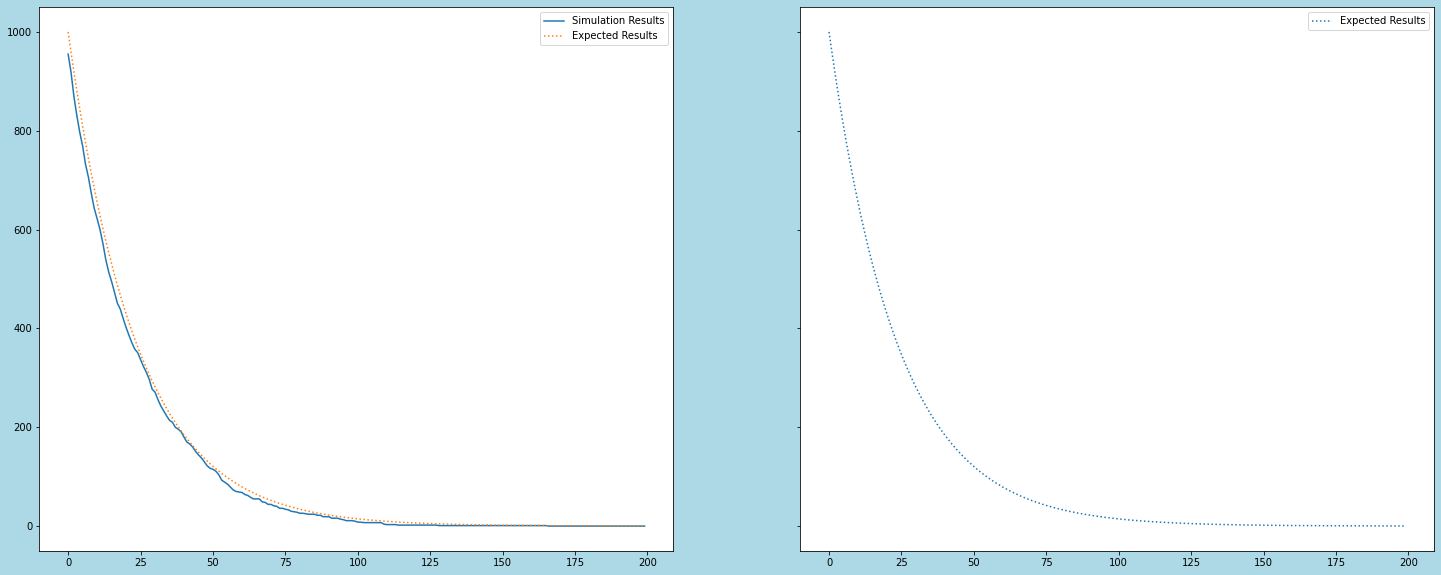

In [7]:
import itertools
import numpy as np


# get the simulation data
ys = N - np.cumsum(np.array(n_time))
xs = np.linspace(0, tmax - 1, len(ys))
# get the expected data from the formula
zs = [n(t, characteristic_time, N, k, T, activation_energy) for t in xs]


import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(25,10), facecolor='lightblue')


# plot the simulation data
axes[0].plot(xs, ys, label='Simulation Results')
# plot expected data
axes[0].plot(xs, zs, label='Expected Results', linestyle=':')
axes[0].legend()


# get the expected data from the formula
zs = n_inf(characteristic_time, N, k, T, activation_energy, tmax)
axes[1].plot(xs, zs, label='Expected Results', linestyle=':')
axes[1].legend()

f = open("demofile2.csv", "a")

for i in range(len(ys)):
    f.write(f"{xs[i]}, {ys[i]}\n")
f.close()